Objektif

1.  Total pendapatan penjualan berdasarkan bulan
2.  Analisis penjualan menurut negara bagian
3.  Identifikasi 10 produk terlaris berdasarkan jumlah order di Sao Paulo
4.  Identifikasi 10 produk berdasarkan jumlah total pendapatan di Sao Paulo
5.  Identifikasi 10 produk dengan rata-rata rating tertinggi di Sao Paulo



In [23]:
# iomport library sesuai kebutuhan
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# konek ke database olist
conn = sqlite3.connect('/content/drive/MyDrive/SQL Data Wrangling/olist.db')

In [4]:
# analisa tren penjualan
# query menghitung total pendapatan penjualan berdasarkan bulan:
query1 = """
SELECT
  strftime('%Y-%m', order_purchase_timestamp) AS month,
  SUM(payment_value) AS total_revenue
FROM
  olist_order_dataset
  JOIN olist_order_payments_dataset
    ON olist_order_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY
  month
ORDER BY
  month ASC
;"""

# convert SQL query ke DataFrame
df1 = pd.read_sql(query1, conn)
df1

,month,total_revenue
0,2016-09,252.24
1,2016-10,59090.48
2,2016-12,19.62
3,2017-01,138488.04
4,2017-02,291908.01
5,2017-03,449863.60
6,2017-04,417788.03
7,2017-05,592918.82
8,2017-06,511276.38
9,2017-07,592382.92


In [5]:
# data cleaning
# memanggil 2 tabel yang digunakan dari query di atas
df_order = pd.read_sql_query("SELECT * FROM olist_order_dataset", conn)
df_payments = pd.read_sql_query("SELECT * FROM olist_order_payments_dataset", conn)

# cek missing values
print(df_order.isnull().sum())
print(df_payments.isnull().sum())

# menghapus missing values
df_order = df_order.dropna()
df_payments = df_payments.dropna()

# cek duplicates
print(df_order.duplicated().sum())
print(df_payments.duplicated().sum())

# menghapus duplicates
df_order = df_order.drop_duplicates(subset=['order_id'])
df_payments = df_payments.drop_duplicates(subset=['order_id'])

# cek relevansi data dan memastikan diantara 2 tabel terhubung
print(df_order['order_id'].nunique())
print(df_payments['order_id'].nunique())

# join 2 tabel dan menghitung total pendapatan
df = pd.merge(df_order, df_payments, on='order_id')
df['month'] = pd.to_datetime(df['order_purchase_timestamp']).dt.to_period('M')
df_revenue = df.groupby('month').agg({'payment_value': 'sum'}).reset_index()

# convert month column ke datetime type
df_revenue['month'] = df_revenue['month'].dt.to_timestamp()

# print data
print(df_revenue)

index                               0
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
index                   0
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
0
0
96461
99440
        month  payment_value
0  2016-10-01       46540.32
1  2016-12-01          19.62
2  2017-01-01      124784.64
3  2017-02-01      264729.31
4  2017-03-01      408346.41
5  2017-04-01      379941.40
6  2017-05-01      553013.28
7  2017-06-01      482407.54
8  2017-07-01      554146.60
9  2017-08-01      634502.92
10 2017-09-01      687229.06
11 2017-10-01      737440.61
12 2017-11-01     1136173.83
13 2017-12-01      829460.35
14 2018-01-01     1061179

In [6]:
# check total order tiap bulan untuk memastikan apakah di data 2016-12 revenue sedikit karena jumlah ordernya juga sedikit 
query2 = """
SELECT
  strftime('%Y-%m', order_purchase_timestamp) AS month,
  COUNT(DISTINCT order_id) AS total_orders
FROM
  olist_order_dataset
GROUP BY
  month
ORDER BY
  month ASC
"""
df2 = pd.read_sql_query(query2, conn)

# print data
print(df2)

      month  total_orders
0   2016-09             4
1   2016-10           324
2   2016-12             1
3   2017-01           800
4   2017-02          1780
5   2017-03          2682
6   2017-04          2404
7   2017-05          3700
8   2017-06          3245
9   2017-07          4026
10  2017-08          4331
11  2017-09          4285
12  2017-10          4631
13  2017-11          7544
14  2017-12          5673
15  2018-01          7269
16  2018-02          6728
17  2018-03          7211
18  2018-04          6939
19  2018-05          6873
20  2018-06          6167
21  2018-07          6292
22  2018-08          6512
23  2018-09            16
24  2018-10             4


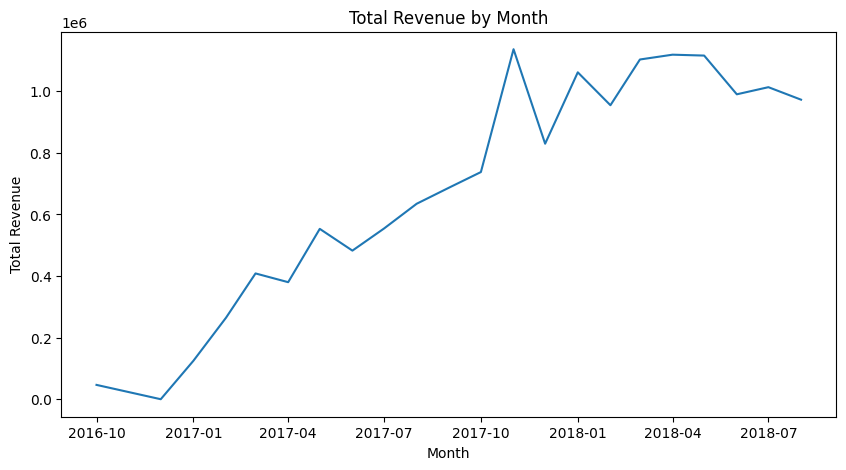

In [7]:
# visualisasi total pendapatan penjualan berdasarkan bulan dan tahun

# mengatur ukuran visualisasi
plt.figure(figsize=(10, 5))

# membuat plot
plt.plot(df_revenue['month'], df_revenue['payment_value'])

# menentukan axis labels and title
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Month')

# menampilkan visualisasi
plt.show()


In [8]:
 # analisis penjualan menurut negara bagian:
query3 = """
 SELECT
  olist_geolocation_dataset.geolocation_state,
  olist_geolocation_dataset.geolocation_city,
  COUNT(DISTINCT olist_order_dataset.customer_id) AS unique_customers,
  COUNT(olist_order_dataset.order_id) AS total_orders,
  SUM(olist_order_payments_dataset.payment_value) AS total_revenue
FROM
  olist_order_dataset
  JOIN olist_order_payments_dataset
    ON olist_order_dataset.order_id = olist_order_payments_dataset.order_id
  JOIN olist_order_customer_dataset
    ON olist_order_dataset.customer_id = olist_order_customer_dataset.customer_id
  JOIN olist_geolocation_dataset
    ON olist_order_customer_dataset.customer_zip_code_prefix = olist_geolocation_dataset.geolocation_zip_code_prefix
GROUP BY
  olist_geolocation_dataset.geolocation_state
ORDER BY
  total_revenue DESC
 ;"""

 # convert SQL query ke DataFrame
df3 = pd.read_sql(query3, conn)
df3

,geolocation_state,geolocation_city,unique_customers,total_orders,total_revenue
0,SP,sao paulo,41730,5886801,8.193250e+08
1,RJ,nilopolis,12839,3159418,5.162149e+08
2,MG,ouro preto,11624,3003847,4.684181e+08
3,RS,santa rosa,5473,832842,1.318863e+08
4,PR,congonhinhas,5034,651271,1.013679e+08
5,SC,imbituba,3651,554050,9.657778e+07
6,BA,barreiras,3371,390029,7.414359e+07
7,ES,serra,2027,327951,5.150720e+07
8,MT,cuiaba,905,127794,2.707581e+07
9,GO,vianopolis,2011,137966,2.457239e+07


geolocation_state    0
geolocation_city     0
unique_customers     0
total_orders         0
total_revenue        0
dtype: int64
0
geolocation_state     object
geolocation_city      object
unique_customers       int64
total_orders           int64
total_revenue        float64
dtype: object
       unique_customers  total_orders  total_revenue
count         27.000000  2.700000e+01   2.700000e+01
mean        3675.407407  5.835573e+05   9.068859e+07
std         8267.664089  1.333467e+06   1.944806e+08
min           46.000000  2.087000e+03   4.624221e+05
25%          380.500000  2.349900e+04   4.853779e+06
50%          905.000000  6.622100e+04   1.324134e+07
75%         2699.000000  3.589900e+05   6.282540e+07
max        41730.000000  5.886801e+06   8.193250e+08


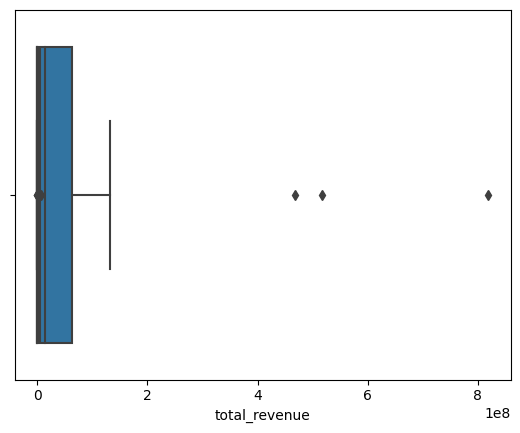

In [11]:
# cek missing values
print(df3.isnull().sum())

# cek duplicates
print(df3.duplicated().sum())

# cek type data masing-masing kolom
print(df3.dtypes)

# cek outliers
print(df3.describe())

# cek distribusi total revenue
num_cols = df3.select_dtypes(include='number').columns
for col in num_cols:
    sns.boxplot(x=df3[col])


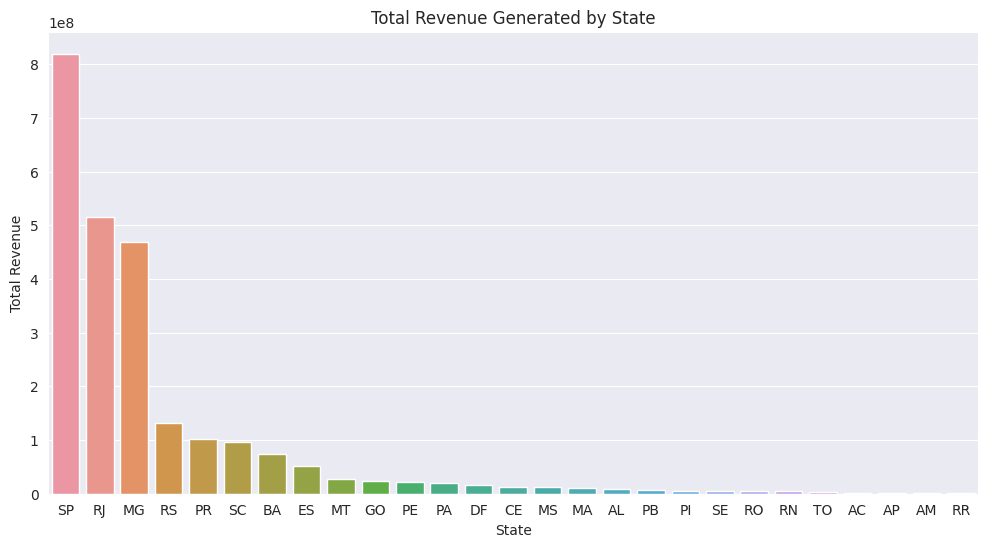

In [13]:
# visualisasi untuk membandingkan total pendapatan dari masing masing negara bagian

# mengatur warna background dan ukuran visualisasi
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))

# membuat barplot
sns.barplot(data=df3, x='geolocation_state', y='total_revenue')

# menentukan axis labels and title
plt.xlabel('State')
plt.ylabel('Total Revenue')
plt.title('Total Revenue Generated by State')

# menampilkan visualisasi
plt.show()

In [15]:
# identifikasi 10 produk terlaris berdasarkan jumlah order di Sao Paulo
query4 = """
SELECT
  olist_products_dataset.product_category_name,
  SUM(olist_order_items_dataset.order_item_id) AS total_quantity_sold
FROM
  olist_order_items_dataset
  JOIN olist_products_dataset
    ON olist_order_items_dataset.product_id = olist_products_dataset.product_id
  JOIN olist_order_dataset
    ON olist_order_items_dataset.order_id = olist_order_dataset.order_id
  JOIN olist_order_customer_dataset
    ON olist_order_dataset.customer_id = olist_order_customer_dataset.customer_id
  JOIN olist_geolocation_dataset
    ON olist_order_customer_dataset.customer_zip_code_prefix = olist_geolocation_dataset.geolocation_zip_code_prefix
WHERE
  olist_geolocation_dataset.geolocation_state = 'SP'
GROUP BY
  olist_products_dataset.product_category_name
ORDER BY
  total_quantity_sold DESC
LIMIT
  10
;"""

# convert SQL query ke DataFrame
df4 = pd.read_sql(query4, conn)
df4

,product_category_name,total_quantity_sold
0,cama_mesa_banho,869265
1,moveis_decoracao,726422
2,beleza_saude,649010
3,esporte_lazer,580552
4,utilidades_domesticas,528353
5,informatica_acessorios,523578
6,ferramentas_jardim,329531
7,relogios_presentes,321245
8,telefonia,255471
9,brinquedos,252520


In [16]:
# cek missing values
print(df4.isnull().sum())

# cek duplicates
print(df4.duplicated().sum())

# cek type data masing-masing kolom
print(df4.dtypes)

# cek outliers
print(df4.describe())

product_category_name    0
total_quantity_sold      0
dtype: int64
0
product_category_name    object
total_quantity_sold       int64
dtype: object
       total_quantity_sold
count            10.000000
mean         503594.700000
std          210713.226751
min          252520.000000
25%          323316.500000
50%          525965.500000
75%          631895.500000
max          869265.000000


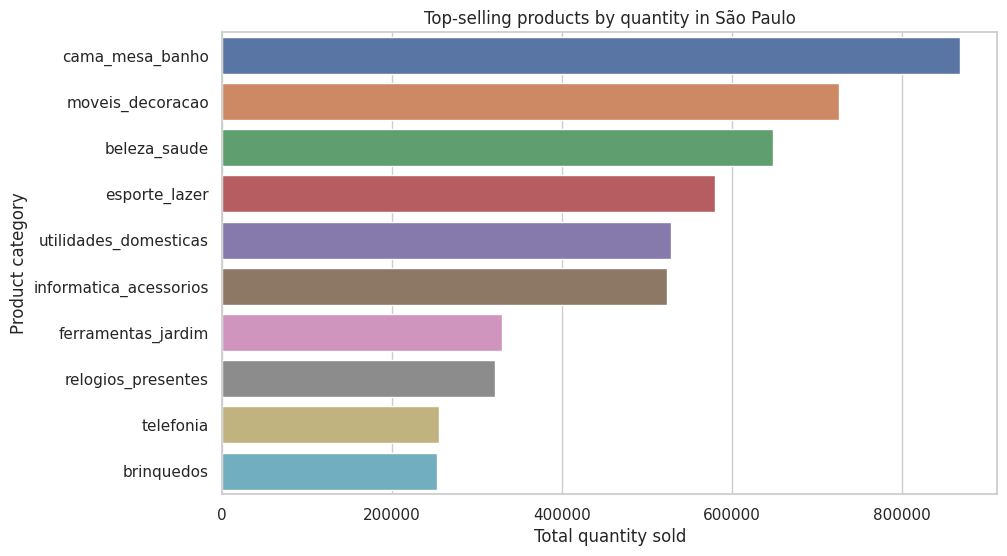

In [17]:
# visualisasi untuk melihat 10 produk terlaris berdasarkan jumlah order di Sao Paulo

# mengatur warna background dan ukuran visualisasi
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# membuat barplot
sns.barplot(x="total_quantity_sold", y="product_category_name", data=df4)

# menentukan axis labels and title
plt.title("Top-selling products by quantity in São Paulo")
plt.xlabel("Total quantity sold")
plt.ylabel("Product category")

# menampilkan visualisasi
plt.show()


In [18]:
# identifikasi 10 produk berdasarkan jumlah total pendapatan di Sao Paulo
query5 = """
SELECT
  olist_products_dataset.product_category_name,
  SUM(olist_order_items_dataset.price) AS total_revenue
FROM
  olist_order_items_dataset
  JOIN olist_products_dataset
    ON olist_order_items_dataset.product_id = olist_products_dataset.product_id
  JOIN olist_order_dataset
    ON olist_order_items_dataset.order_id = olist_order_dataset.order_id
  JOIN olist_order_customer_dataset
    ON olist_order_dataset.customer_id = olist_order_customer_dataset.customer_id
  JOIN olist_geolocation_dataset
    ON olist_order_customer_dataset.customer_zip_code_prefix = olist_geolocation_dataset.geolocation_zip_code_prefix
WHERE
  olist_geolocation_dataset.geolocation_state = 'SP'
GROUP BY
  olist_products_dataset.product_category_name
ORDER BY
  total_revenue DESC
LIMIT
  10
;"""

# convert SQL query ke DataFrame
df5 = pd.read_sql(query5, conn)
df5


,product_category_name,total_revenue
0,cama_mesa_banho,6.709564e+07
1,beleza_saude,6.024898e+07
2,relogios_presentes,5.569904e+07
3,esporte_lazer,5.344309e+07
4,informatica_acessorios,4.706582e+07
5,moveis_decoracao,4.088252e+07
6,utilidades_domesticas,3.774276e+07
7,cool_stuff,2.981115e+07
8,automotivo,2.815039e+07
9,brinquedos,2.531490e+07


In [19]:
# cek missing values
print(df5.isnull().sum())

# cek duplicates
print(df5.duplicated().sum())

# cek type data masing-masing kolom
print(df5.dtypes)

# cek outliers
print(df5.describe())

product_category_name    0
total_revenue            0
dtype: int64
0
product_category_name     object
total_revenue            float64
dtype: object
       total_revenue
count   1.000000e+01
mean    4.454543e+07
std     1.445468e+07
min     2.531490e+07
25%     3.179405e+07
50%     4.397417e+07
75%     5.513505e+07
max     6.709564e+07


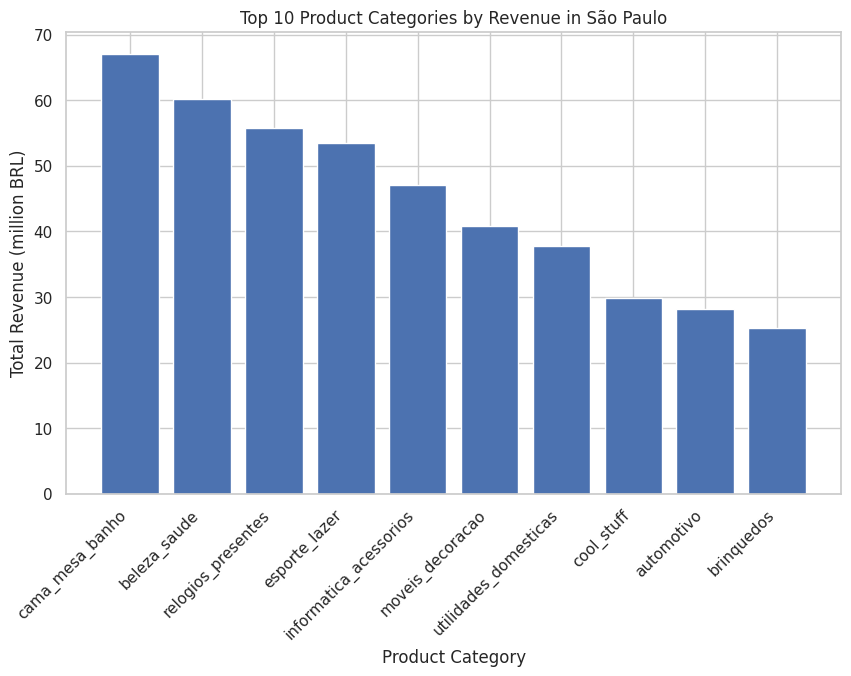

In [20]:
# visualisasi untuk melihat 10 produk berdasarkan jumlah total pendapatan di Sao Paulo

# mengatur ukuran visualisasi
plt.figure(figsize=(10, 6))

# membuat barchart dan mengubah posisi x-axis labels 45 derajat ke arah kanan
plt.bar(df5['product_category_name'], df5['total_revenue'] / 1e6)
plt.xticks(rotation=45, ha='right')

# menentukan axis labels and title
plt.xlabel('Product Category')
plt.ylabel('Total Revenue (million BRL)')
plt.title('Top 10 Product Categories by Revenue in São Paulo')

# menampilkan visualisasi
plt.show()


In [ ]:
# lihat list table
invoice = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
invoice

,name
0,olist_order_customer_dataset
1,olist_order_dataset
2,olist_order_reviews_dataset
3,olist_order_payments_dataset
4,olist_order_items_dataset
5,olist_products_dataset
6,olist_sellers_dataset
7,olist_geolocation_dataset
8,product_category_name_translation


In [21]:
# identifikasi 10 produk dengan rata-rata rating tertinggi di Sao Paulo
query6 = """
SELECT
  olist_products_dataset.product_category_name,
  AVG(olist_order_reviews_dataset.review_score) AS average_rating
FROM
  olist_order_items_dataset
  JOIN olist_products_dataset
    ON olist_order_items_dataset.product_id = olist_products_dataset.product_id
  JOIN olist_order_reviews_dataset
    ON olist_order_items_dataset.order_id = olist_order_reviews_dataset.order_id
  JOIN olist_order_dataset
    ON olist_order_items_dataset.order_id = olist_order_dataset.order_id
  JOIN olist_order_customer_dataset
    ON olist_order_dataset.customer_id = olist_order_customer_dataset.customer_id
  JOIN olist_geolocation_dataset
    ON olist_order_customer_dataset.customer_zip_code_prefix = olist_geolocation_dataset.geolocation_zip_code_prefix
WHERE
  olist_geolocation_dataset.geolocation_state = 'SP'
GROUP BY
  olist_products_dataset.product_category_name
HAVING
  COUNT(DISTINCT olist_order_reviews_dataset.order_id) >= 10 -- Only consider products with at least 10 reviews
ORDER BY
  average_rating DESC
LIMIT
  10
;"""

# convert SQL query ke DataFrame
df6 = pd.read_sql(query6, conn)
df6

,product_category_name,average_rating
0,flores,4.716316
1,tablets_impressao_imagem,4.682873
2,livros_tecnicos,4.596678
3,fashion_esporte,4.547592
4,artes_e_artesanato,4.442482
5,malas_acessorios,4.439739
6,livros_interesse_geral,4.434466
7,livros_importados,4.414028
8,artigos_de_natal,4.412423
9,papelaria,4.404064


product_category_name    0
average_rating           0
dtype: int64
0
       average_rating
count       10.000000
mean         4.509066
std          0.118568
min          4.404064
25%          4.419137
50%          4.441110
75%          4.584406
max          4.716316
flores                      1
tablets_impressao_imagem    1
livros_tecnicos             1
fashion_esporte             1
artes_e_artesanato          1
malas_acessorios            1
livros_interesse_geral      1
livros_importados           1
artigos_de_natal            1
papelaria                   1
Name: product_category_name, dtype: int64
All ratings are within the range of 1 to 5


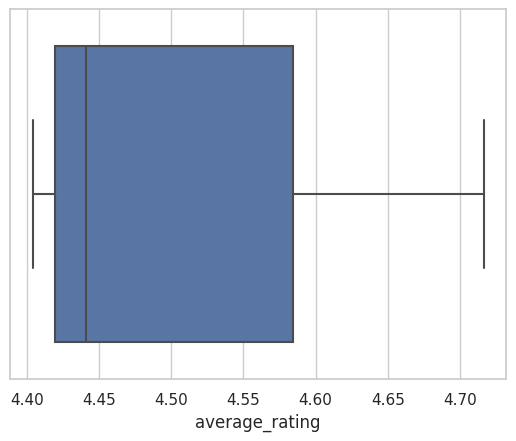

In [24]:
# cek missing values
print(df6.isnull().sum())

# cek duplicates
print(df6.duplicated().sum())

# cek outliers
print(df6.describe())

# hitung jumlah kemunculan setiap nama kategori produk
category_counts = df6['product_category_name'].value_counts()
print(category_counts)

# memastikan rating rangenya 1 sampai dengan 5
ratings = df6['average_rating']
if np.all((ratings >= 1) & (ratings <= 5)):
    print("All ratings are within the range of 1 to 5")
else:
    print("There are ratings outside the range of 1 to 5")

# cek distribusi data
num_cols = df6.select_dtypes(include='number').columns
for col in num_cols:
    sns.boxplot(x=df6[col])

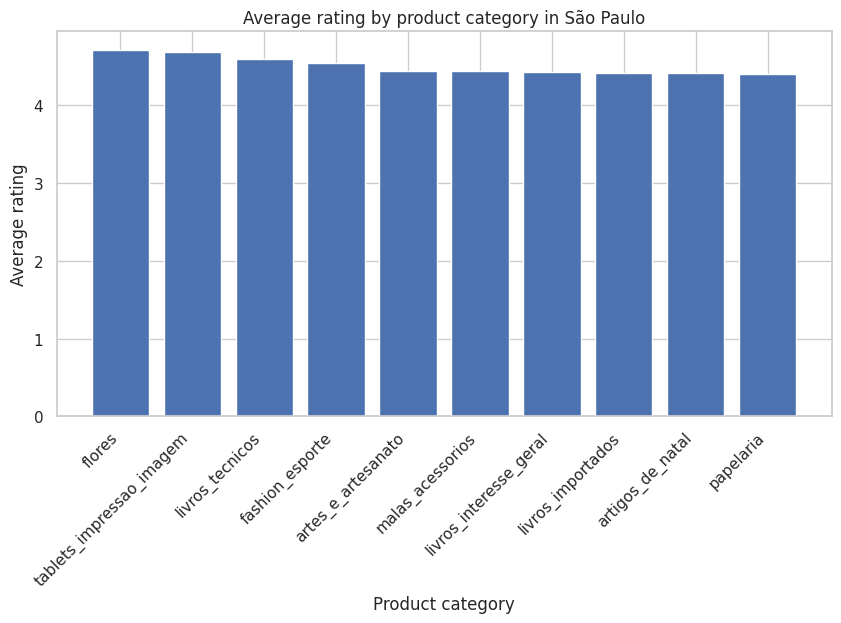

In [26]:
# visualisasi untuk melihat 10 produk dengan rata-rata rating tertinggi di Sao Paulo

# mengatur ukuran visualisasi
plt.figure(figsize=(10, 5))

# membuat barchart dan mengubah posisi x-axis labels 45 derajat ke arah kanan
plt.bar(df6['product_category_name'], df6['average_rating'])
plt.xticks(rotation=45, ha='right')

# menentukan axis labels and title
plt.title('Average rating by product category in São Paulo')
plt.xlabel('Product category')
plt.ylabel('Average rating')

# menampilkan visualisasi
plt.show()
